## Easy way to work with unstructured grids - with minimal dependency on packages

There are several ways to perform interpolation from unstructured (FESOM2, ICON) to regular grid from command line tools like `cdo` to specialised python packages like [`pyfesom2`](https://github.com/FESOM/pyfesom2/) or [`pyicon`](https://gitlab.dkrz.de/m300602/pyicon). We will cover them in other chapters - here we show the way of how to interpolate unstructured grid data usual scientific python packages, that are most probably already available on your system (numpy, scipy, matplotlib, xarray).

In [1]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import scipy.spatial.qhull as qhull
import matplotlib.tri as mtri
%matplotlib inline
xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays

ValueError: argument names set(['display_style']) are not in the set of valid options set(['arithmetic_join', 'display_width'])

Unstructured meshes look scary at first:

<img src="./images/fig_geometry.png" style="width: 800px;">

But for practical purposes you can have very simple high-level conceptual image of the meshes, as scatter data, that have lon lat coordinates associated with each data point. We will develop it further, but let's stick to this though for a while. To work with this data initially we need coordinates and some data.

In [122]:
#fesom
data = xr.open_dataset('/work/bk1040/DYAMOND/.input_winter_data/IFS-FESOM2-4km/sst.fesom.2020.nc')

In [123]:
#icon
dataICON = xr.open_dataset('/work/mh0731/m300845/hackathon/dpp0029/raw_model_output/dpp0033/dpp0033_ocean3D_24h_20210121T000000Z.nc')

In [124]:
data, dataICON

(<xarray.Dataset>
 Dimensions:  (nod2: 912469, time: 960)
 Coordinates:
   * time     (time) datetime64[ns] 2020-01-20T00:40:00 ... 2020-02-28T23:40:00
 Dimensions without coordinates: nod2
 Data variables:
     sst      (time, nod2) float32 ...,
 <xarray.Dataset>
 Dimensions:        (depth: 128, depth_2: 129, ncells: 14886338, ncells_2: 22375924, ncells_3: 7487687, time: 1)
 Coordinates:
   * depth          (depth) float64 3.5 8.0 10.5 ... 4.734e+03 5.185e+03
   * depth_2        (depth_2) float64 0.0 7.0 9.0 ... 4.949e+03 5.421e+03
   * time           (time) datetime64[ns] 2021-01-21
 Dimensions without coordinates: ncells, ncells_2, ncells_3
 Data variables:
     to             (time, depth, ncells) float32 ...
     so             (time, depth, ncells) float32 ...
     u              (time, depth, ncells) float32 ...
     v              (time, depth, ncells) float32 ...
     w              (time, depth_2, ncells) float32 ...
     A_tracer_v_to  (time, depth_2, ncells) float32 ...
   

The grid description, including coordinates of the data points are usually stored in a separate file.

In [125]:
#fesom
grid = xr.open_dataset('/work/ab0995/a270046/fesom2-meshes/NEMO_ecmwf/NEMO/NEMO.grid.CDO.nc')

In [126]:
grid

<xarray.Dataset>
Dimensions:          (Three: 3, ncells: 912469, nlinks_max: 6, ntriags: 1801435, vertices: 12)
Coordinates:
    lon              (ncells) float64 ...
    lat              (ncells) float64 ...
Dimensions without coordinates: Three, ncells, nlinks_max, ntriags, vertices
Data variables:
    lon_bnds         (ncells, vertices) float64 ...
    lat_bnds         (ncells, vertices) float64 ...
    cell_area        (ncells) float64 ...
    node_node_links  (ncells, nlinks_max) float64 ...
    triag_nodes      (ntriags, Three) float64 ...
    coast            (ncells) float64 ...
Attributes:
    Conventions:  CF-1.4
    history:      Grid description file generated with spheRlab sl.grid.writeCDO

In [127]:
#icon
gridICON = xr.open_dataset('/work/mh0731/m300845/hackathon/dpp0029/grid_files/icon_grid_0016_R02B09_O.nc')

In [128]:
gridICON

<xarray.Dataset>
Dimensions:                         (cell: 14886338, cell_grf: 14, edge: 22375924, edge_grf: 24, max_chdom: 1, max_stored_decompositions: 4, nc: 2, ne: 6, no: 4, nv: 3, two_grf: 2, vert_grf: 13, vertex: 7487687)
Coordinates:
    clon                            (cell) float64 ...
    clat                            (cell) float64 ...
    vlon                            (vertex) float64 ...
    vlat                            (vertex) float64 ...
    elon                            (edge) float64 ...
    elat                            (edge) float64 ...
Dimensions without coordinates: cell, cell_grf, edge, edge_grf, max_chdom, max_stored_decompositions, nc, ne, no, nv, two_grf, vert_grf, vertex
Data variables:
    clon_vertices                   (cell, nv) float64 ...
    clat_vertices                   (cell, nv) float64 ...
    vlon_vertices                   (vertex, ne) float64 ...
    vlat_vertices                   (vertex, ne) float64 ...
    elon_vertices                   (edge, no) float64 ...
    elat_vertices                   (edge, no) float64 ...
    ifs2icon_cell_grid              (cell) float64 ...
    ifs2icon_edge_grid              (edge) float64 ...
    ifs2icon_vertex_grid            (vertex) float64 ...
    cell_area                       (cell) float64 ...
    dual_area                       (vertex) float64 ...
    phys_cell_id                    (cell) int32 ...
    phys_edge_id                    (edge) int32 ...
    lon_cell_centre                 (cell) float64 ...
    lat_cell_centre                 (cell) float64 ...
    lat_cell_barycenter             (cell) float64 ...
    lon_cell_barycenter             (cell) float64 ...
    longitude_vertices              (vertex) float64 ...
    latitude_vertices               (vertex) float64 ...
    lon_edge_centre                 (edge) float64 ...
    lat_edge_centre                 (edge) float64 ...
    edge_of_cell                    (nv, cell) int32 ...
    vertex_of_cell                  (nv, cell) int32 ...
    adjacent_cell_of_edge           (nc, edge) int32 ...
    edge_vertices                   (nc, edge) int32 ...
    cells_of_vertex                 (ne, vertex) int32 ...
    edges_of_vertex                 (ne, vertex) int32 ...
    vertices_of_vertex              (ne, vertex) int32 ...
    cell_area_p                     (cell) float64 ...
    cell_elevation                  (cell) float64 ...
    cell_sea_land_mask              (cell) int32 ...
    cell_domain_id                  (cell, max_stored_decompositions) int32 ...
    cell_no_of_domains              (max_stored_decompositions) int32 ...
    dual_area_p                     (vertex) float64 ...
    edge_length                     (edge) float64 ...
    edge_cell_distance              (nc, edge) float64 ...
    dual_edge_length                (edge) float64 ...
    edgequad_area                   (edge) float64 ...
    edge_elevation                  (edge) float64 ...
    edge_sea_land_mask              (edge) int32 ...
    edge_vert_distance              (nc, edge) float64 ...
    zonal_normal_primal_edge        (edge) float64 ...
    meridional_normal_primal_edge   (edge) float64 ...
    zonal_normal_dual_edge          (edge) float64 ...
    meridional_normal_dual_edge     (edge) float64 ...
    orientation_of_normal           (nv, cell) int32 ...
    cell_index                      (cell) int32 ...
    parent_cell_index               (cell) int32 ...
    parent_cell_type                (cell) int32 ...
    neighbor_cell_index             (nv, cell) int32 ...
    child_cell_index                (no, cell) int32 ...
    child_cell_id                   (cell) int32 ...
    edge_index                      (edge) int32 ...
    edge_parent_type                (edge) int32 ...
    vertex_index                    (vertex) int32 ...
    edge_orientation                (ne, vertex) int32 ...
    edge_system_orientation         (edge) int32 ...
    refin_c_ctrl               

To simplify matters we create separate variables, that would contain coordinates and one time step of surface data data:

In [129]:
#fesom vertices
model_lon = grid.lon.values
model_lat = grid.lat.values
data_sample = data.sst[0,:].values

In [130]:
#icon cells
model_lon_icon = gridICON.clon.values*180./np.pi
model_lat_icon = gridICON.clat.values*180./np.pi
data_sample_icon = dataICON.to[0,0,:].values # to (time, depth, ncells) float32 ...

Very simple way to look at the data is to plot them as dots

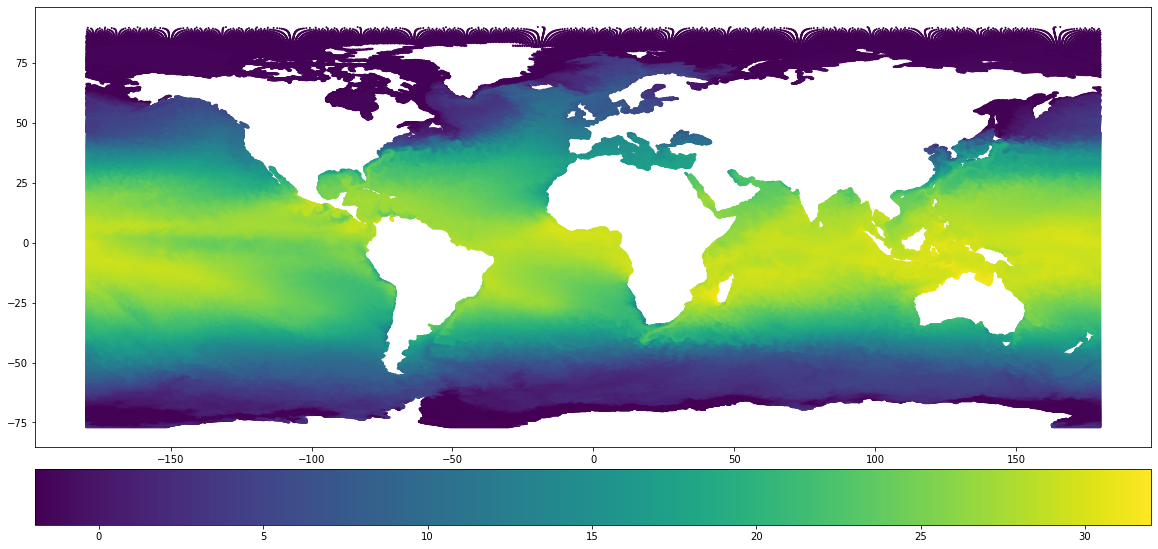

In [131]:
#fesom
plt.figure(figsize=(20,10))
plt.scatter(model_lon, model_lat, s=1 , c=data_sample)
plt.colorbar(orientation='horizontal', pad=0.04)

In [ ]:
#icon
plt.figure(figsize=(20,10))
plt.scatter(model_lon_icon, model_lat_icon, s=1 , c=data_sample_icon)
plt.colorbar(orientation='horizontal', pad=0.04)

Already with 1M points (FESOM) the plots are not extremelly fast, with ICON (14M) even less, so one can use less points:

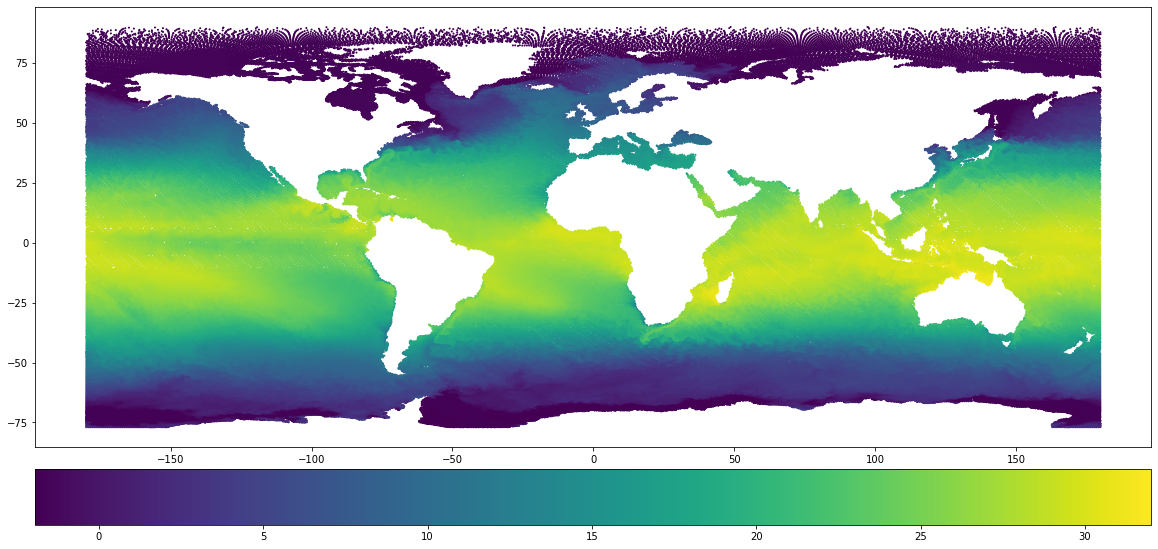

In [134]:
#fesom
sstep = 3
plt.figure(figsize=(20,10))
plt.scatter(model_lon[::sstep], model_lat[::sstep], s=1 , c=data_sample[::sstep])
plt.colorbar(orientation='horizontal', pad=0.04)

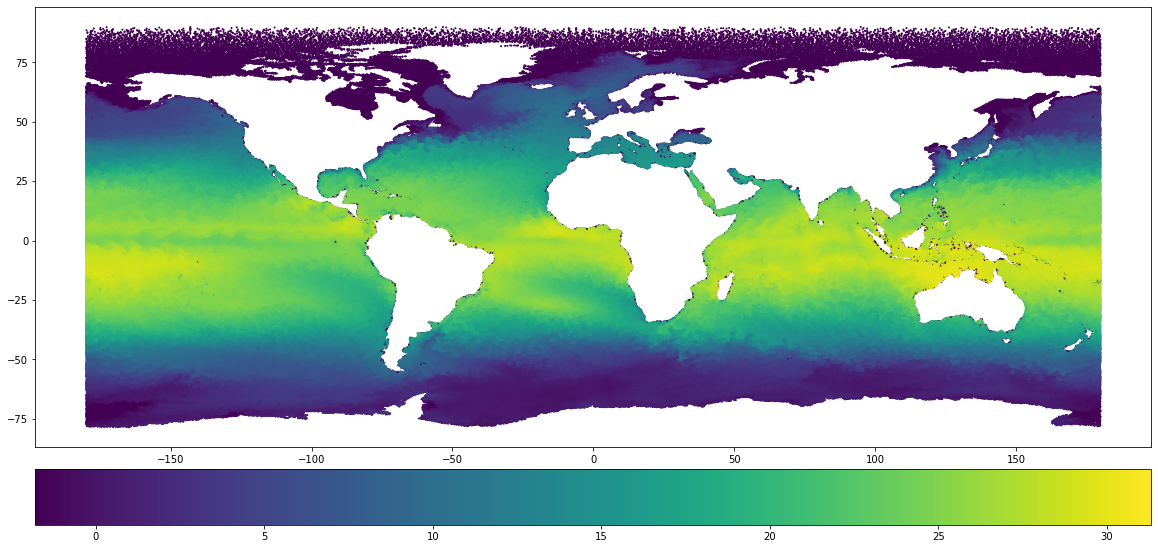

In [135]:
#icon
sstep = 14
plt.figure(figsize=(20,10))
plt.scatter(model_lon_icon[::sstep], model_lat_icon[::sstep], s=1 , c=data_sample_icon[::sstep])
plt.colorbar(orientation='horizontal', pad=0.04)

#### Cut a region including Barbados. EUREC4A operations focus on an area over the shelf oceans east of Barbados (57°W, 13°N) for a 6-week period between 12 January and and 23 February 2020, with aircraft operations between 20 January and 20 February 2020.
https://eurec4a.eu/overview

In [136]:
left = -90
right = -10
bottom = 0
top = 26

In [137]:
#fesom
region = (model_lon < right) & (model_lon>left) & (model_lat > bottom) & (model_lat < top)

In [140]:
region.shape

(912469,)

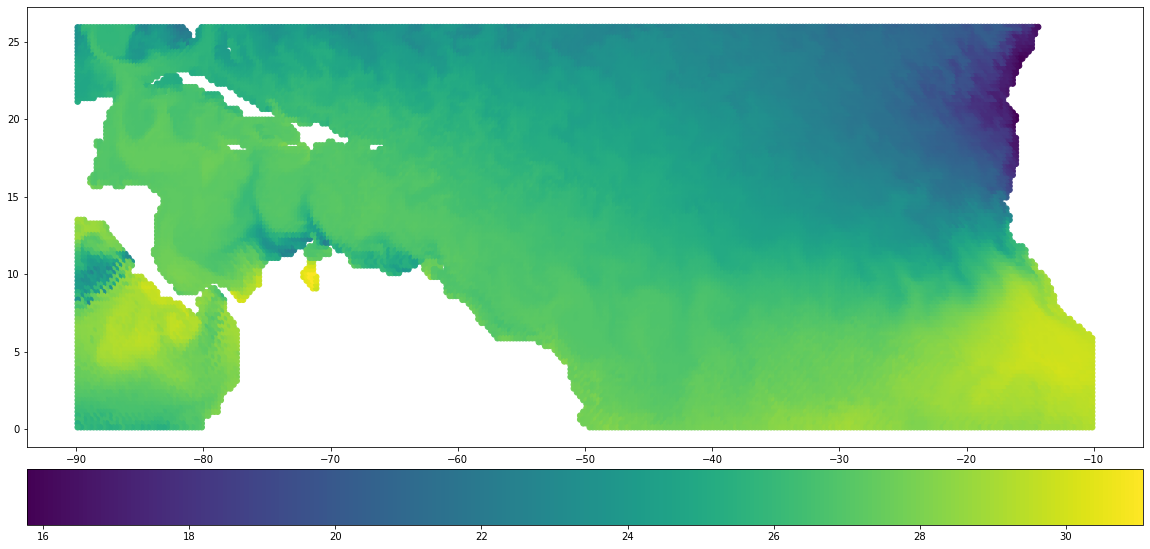

In [146]:
sstep = 1
plt.figure(figsize=(20,10))
plt.scatter(model_lon[region][::sstep], model_lat[region][::sstep], s=30 , c=data_sample[region][::sstep])
plt.colorbar(orientation='horizontal', pad=0.04)

In [147]:
#icon
regionICON = (model_lon_icon < right) & (model_lon_icon>left) & (model_lat_icon > bottom) & (model_lat_icon < top)

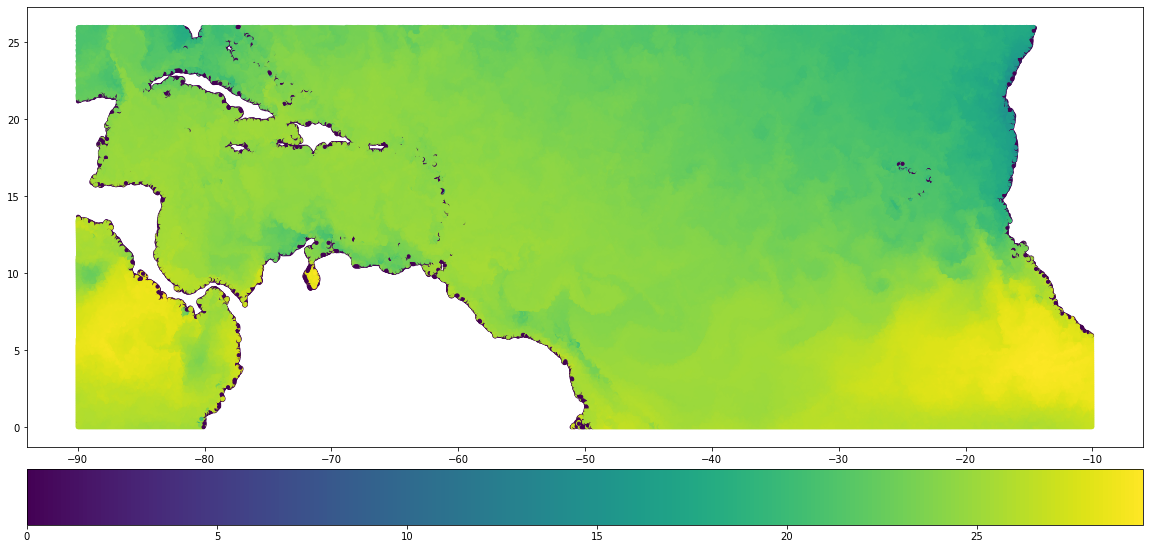

In [148]:
sstep = 1
plt.figure(figsize=(20,10))
plt.scatter(model_lon_icon[regionICON][::sstep], 
            model_lat_icon[regionICON][::sstep], 
            s=10 , c=data_sample_icon[regionICON][::sstep])
plt.colorbar(orientation='horizontal', pad=0.04)

## Simple scatter maps

If you are lucky enough to have cartopy installed on your system (as on DKRZ), then you can even put this into a map:

In [149]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

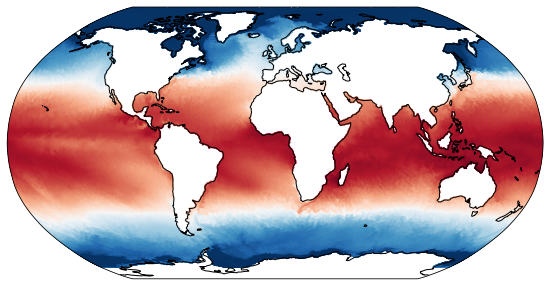

In [150]:
#fesom
sstep = 3
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')
ax.scatter(model_lon[::sstep], model_lat[::sstep], s=1 , c=data_sample[::sstep],
            cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

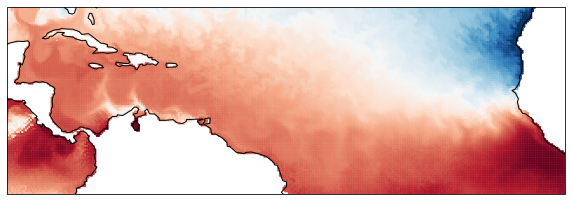

In [151]:
#fesom
sstep = 1
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
ax.scatter(model_lon[::sstep], model_lat[::sstep], s=2 , c=data_sample[::sstep], 
           vmin=17, vmax=30,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

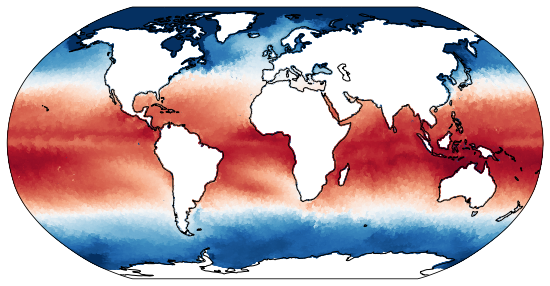

In [152]:
#icon
sstep = 14
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')
ax.scatter(model_lon_icon[::sstep], model_lat_icon[::sstep], s=1 , c=data_sample_icon[::sstep],
            cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

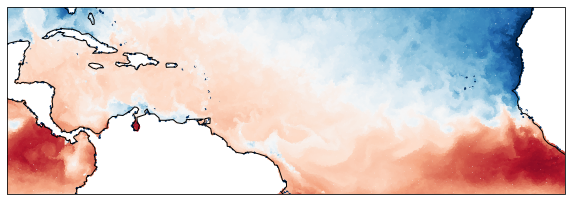

In [153]:
#icon
sstep = 14
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
ax.scatter(model_lon_icon[::sstep], model_lat_icon[::sstep], s=2 , c=data_sample_icon[::sstep], 
           vmin=17, vmax=30,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

Not entirely ideal, but if you want to have something quick and dirty, this is the way.

## Simple interpolation to a regular grid

The next step would be to get the data to a regular grid, so that one can compare to observations, or do better plots. For the pre-Hackathon, ICON data was provided remapped (with CDO) to a regular grid, https://pad.gwdg.de/qtqOBOH7TTG1HpXPoqM8SQ?both , and FESOM can be remapped with cdo too. We can also do this internally for both models in Python as follows.

Let's define a small region in the open ocean, which has no land. You need to generate 2D lat lon coordinates, so that for every point of our grid we have coordinates.

In [154]:
lon = np.linspace(-70, -60, 80)
lat = np.linspace(30, 40, 80)
lon2, lat2 = np.meshgrid(lon, lat)

For `scipy` interpolation functions we have to put coordinates in particularelly shaped array: 

In [155]:
#fesom
points = np.vstack((model_lon, model_lat)).T
#icon
points_icon = np.vstack((model_lon_icon, model_lat_icon)).T
points, points_icon

(array([[-107.4304,   66.8853],
        [-107.3679,   66.9388],
        [-107.5654,   66.829 ],
        ...,
        [  72.625 ,   21.5941],
        [  72.375 ,   22.057 ],
        [  72.625 ,   21.8258]]),
 array([[ 73.        ,  72.14153539],
        [ 73.11610713,  72.11842828],
        [ 73.        ,  72.17353504],
        ...,
        [ 76.49297292, -45.17171677],
        [ 76.54481611, -45.23138792],
        [ 76.4503828 , -45.23383705]]))

### nearest neighbor

The simplest method of interpolation is nearest-neighbor. First we have to generate an interpolation function from coordinates (`points`) and data (`data_sample`)

In [156]:
%%time
nn_interpolation = NearestNDInterpolator(points, data_sample)

CPU times: user 352 ms, sys: 11 ms, total: 363 ms
Wall time: 357 ms


And now interpolate our data to another grid:

In [157]:
%%time
interpolated_nn_fesom = nn_interpolation((lon2, lat2))

CPU times: user 8 ms, sys: 2 ms, total: 10 ms
Wall time: 7.39 ms


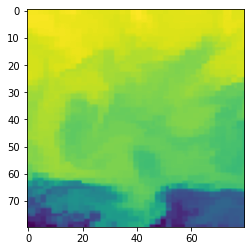

In [158]:
plt.imshow(interpolated_nn_fesom)

Do the same for ICON:

In [159]:
%%time
nn_interpolation_icon = NearestNDInterpolator(points_icon, data_sample_icon)

CPU times: user 5.83 s, sys: 307 ms, total: 6.14 s
Wall time: 6.13 s


In [160]:
%%time
interpolated_nn_icon = nn_interpolation_icon((lon2, lat2))

CPU times: user 18 ms, sys: 3 ms, total: 21 ms
Wall time: 17.7 ms


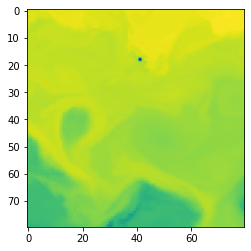

In [161]:
plt.imshow(interpolated_nn_icon)

This method is relatively fast, and it's ok to use for most visualization purposes. However, there are other methods available:

In [ ]:
# del nn_interpolation,nn_interpolation_icon

### linear

Much slower, but should be more precise in many cases:

In [162]:
%%time
linear_interpolation_fesom = LinearNDInterpolator(points, data_sample)

CPU times: user 14 s, sys: 247 ms, total: 14.3 s
Wall time: 14.3 s


In [163]:
%%time
interpolated_ln_fesom = linear_interpolation_fesom((lon2, lat2))

CPU times: user 2.76 s, sys: 1 ms, total: 2.76 s
Wall time: 2.76 s


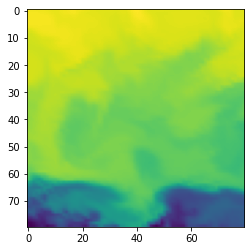

In [164]:
plt.imshow(interpolated_ln_fesom)

Difference to nearest neighbor:

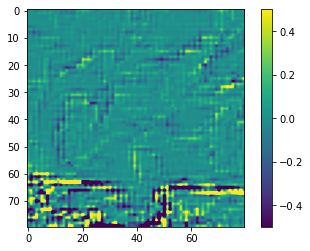

In [165]:
plt.imshow(interpolated_ln_fesom-interpolated_nn_fesom, vmin=-0.5, vmax=0.5)
plt.colorbar()

### bilinear

In [166]:
%%time
bilinear_interpolation = CloughTocher2DInterpolator(points, data_sample)

CPU times: user 17 s, sys: 23 ms, total: 17.1 s
Wall time: 17.1 s


In [167]:
%%time
interpolated_bln_fesom = bilinear_interpolation((lon2, lat2))

CPU times: user 2.77 s, sys: 3 ms, total: 2.77 s
Wall time: 2.77 s


Difference between linear and bilinear interpolations:

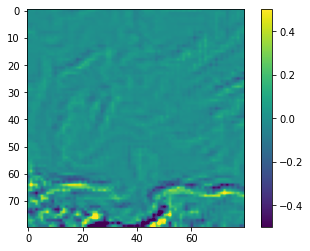

In [168]:
plt.imshow(interpolated_ln_fesom-interpolated_bln_fesom, vmin=-0.5, vmax=0.5)
plt.colorbar()

## Data with boundaries

If your data covers the whole globe (as in case of atmospheric models), your life is easy. Boundaries introduce a new level of complications, and it's a bit harder to use standard methods of interpolation in their presence. However in the end you get acceptable result, if you cover ugly parts by land :): 

In [169]:
lon = np.linspace(-100, -10, 90*4)
lat = np.linspace(-10, 30, 40*4)
lon2, lat2 = np.meshgrid(lon, lat)

In [170]:
%%time
nn_interpolation_fesom = NearestNDInterpolator(points, data_sample)
fesom_interpolated_global = nn_interpolation_fesom((lon2, lat2))

CPU times: user 432 ms, sys: 4 ms, total: 436 ms
Wall time: 431 ms


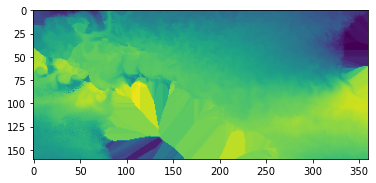

In [171]:
plt.imshow(np.flipud(fesom_interpolated_global))

In [172]:
%%time
nn_interpolation_icon = NearestNDInterpolator(points_icon, data_sample_icon)
icon_interpolated_global = nn_interpolation_icon((lon2, lat2))

CPU times: user 6.26 s, sys: 16 ms, total: 6.28 s
Wall time: 6.27 s


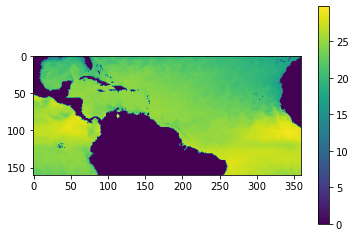

In [173]:
plt.imshow(np.flipud(icon_interpolated_global))
plt.colorbar()

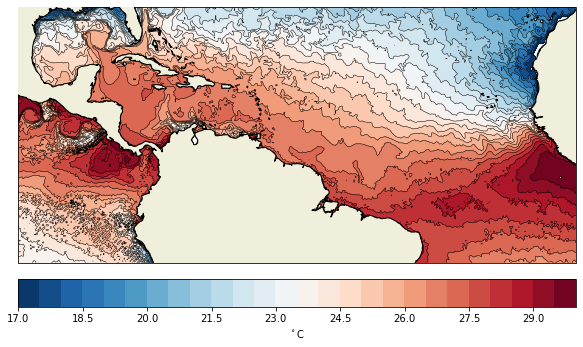

In [176]:
sstep = 1
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
#ax.stock_img()
img = ax.contourf(lon, lat, fesom_interpolated_global, 
           levels = np.linspace(17,30,27),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
ax.contour(lon, lat, fesom_interpolated_global, 
           levels = np.linspace(17,30,27),
           transform=ccrs.PlateCarree(), colors='k', linewidths=0.5)
#ax.add_feature(
#            cfeature.GSHHSFeature(levels=[1], scale="low", facecolor="lightgray")
#        )
#ax.stock_img()
ax.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

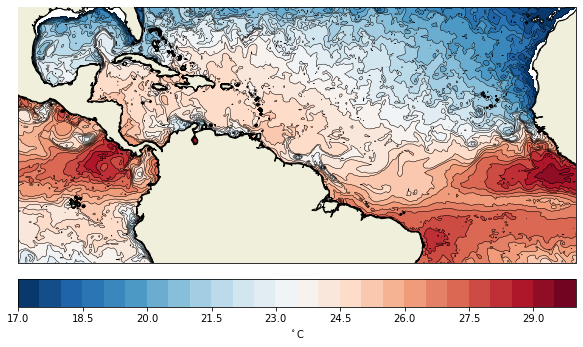

In [177]:
sstep = 1
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
img = ax.contourf(lon2, lat2, icon_interpolated_global, 
           levels = np.linspace(17,30,27),
           #levels = np.linspace(-2,30,27),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
ax.contour(lon2, lat2, icon_interpolated_global, 
           levels = np.linspace(17,30,27),
           #levels = np.linspace(-2,30,27),
           transform=ccrs.PlateCarree(), zorder=10, colors='k', linewidths=0.5)
ax.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
#ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

### Interpolate to grid from observations

Uncomment to download the data ([Source](https://psl.noaa.gov/data/gridded/data.cobe.html)) This is low resolution SST reanalysis.

In [ ]:
#!wget ftp://ftp.cdc.noaa.gov/Datasets/COBE/sst.mon.mean.nc

Open the observational data

In [178]:
obs_file = xr.open_dataset('./sst.mon.mean.nc')

In [179]:
obs_file

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1568)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2021-08-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

Get lon lats from the observations

In [180]:
lon_sst = obs_file.lon.data
lat_sst = obs_file.lat.data

The longitudes are in 0-360 format, but we want them to be in the same [-180 180] format as our models

In [184]:
lon_sst_mod = np.where(lon_sst>180, lon_sst-360, lon_sst)

And we need the coordinates in 2D:

In [185]:
lon_sst2, lat_sst2 = np.meshgrid(lon_sst_mod, lat_sst)

In [186]:
lon_sst2

array([[ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       ...,
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5]], dtype=float32)

In [187]:
fesom_on_obs_grid = NearestNDInterpolator(points, data_sample)(lon_sst2, lat_sst2)

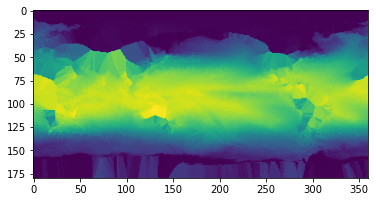

In [188]:
plt.imshow(fesom_on_obs_grid)

In [189]:
icon_on_obs_grid = NearestNDInterpolator(points_icon, data_sample_icon)(lon_sst2, lat_sst2)

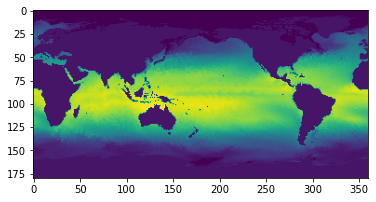

In [190]:
plt.imshow(icon_on_obs_grid)

In [191]:
obs_sample = obs_file.sst.sel(time='2020-01').data[0,:,:]

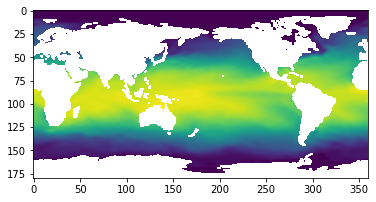

In [192]:
plt.imshow(obs_sample)

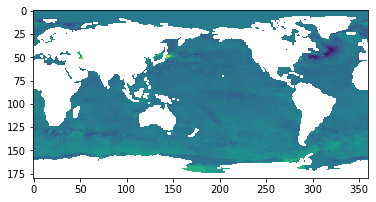

In [193]:
plt.imshow(fesom_on_obs_grid-obs_sample)

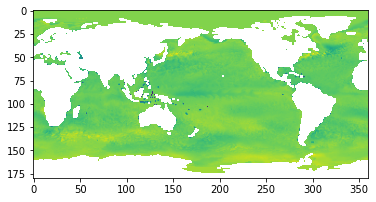

In [194]:
plt.imshow(icon_on_obs_grid-obs_sample)

The observational data are for different averaging periods, and in case of ICON for different year, so don't make any conclussions out of those plots! :)

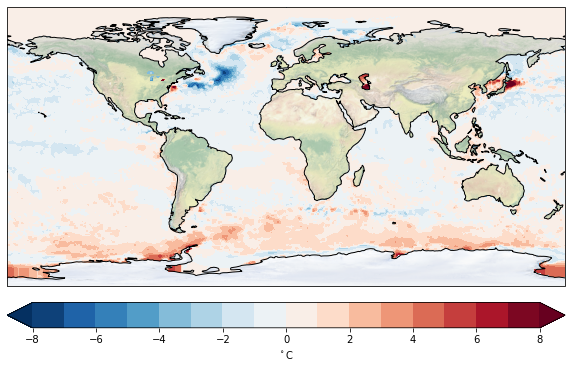

In [195]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k')
img = ax.contourf(lon_sst, lat_sst, fesom_on_obs_grid-obs_sample, 
           levels = np.linspace(-8,8,17),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both')
ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

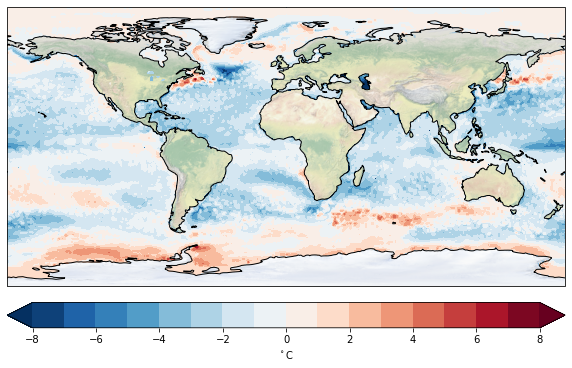

In [196]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k')
img = ax.contourf(lon_sst, lat_sst, icon_on_obs_grid-obs_sample, 
           levels = np.linspace(-8,8,17),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both')
ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

## Advanced interpolation, taking triangles into account (only FESOM, since need data on vertices).

Let's interpolate the data to regular grid once again:

In [ ]:
lon = np.linspace(-100, -10, 90*4)
lat = np.linspace(-10, 30, 40*4)
lon2, lat2 = np.meshgrid(lon, lat)

In [ ]:
%%time
nn_interpolation_fesom = NearestNDInterpolator(points, data_sample)
fesom_data = nn_interpolation_fesom((lon2, lat2))

In [ ]:
plt.imshow(plt.flipud(fesom_data))

What if we don't want to interpolate over land, that do not exist in our mesh anyway?

We have to provide information about geometry of our cells (triangles in our case).

In [ ]:
elements = grid.triag_nodes.data.astype('int32') - 1

We substract 1, since counting in Fortran starts from 1, while in python it starts from 0. 

In [ ]:
elements

Each row in this array is a triangle, and each value in the row is the index of vertices, so that:

In [ ]:
elements[0,:]

In [ ]:
model_lon[elements[0,:]] 

In [ ]:
model_lat[elements[0,:]]

Since tracer data in FESOM2 located on vertices of triangles, we can do this to get the values for the first triangle:

In [ ]:
data_sample[elements[0,:]]

And the mean value for triangle will be:

In [ ]:
data_sample[elements[0,:]].mean()

You should just have elements to create triangulation. Unfortunatelly elements that we get from FESOM2 are not ideal for plotting, since some of the triangles have coordinates like:

    [ 176.9465, -179.3587,  163.4757]
    
This triangle is close to +-180 meredian, and this is not valid for matplotlib triangulation (thinks that triangles are overlaping). The easiest way to deal with it is to remove triangles, that have this kind of points. Something you certainly don't want to do for computing integrals, but for most simple analysis and visualizations is fine.

We search for elements that have lon coordinates that differe by 100 degrees and return a list (`no_cyclic_elem`) of elements that don't have such elements.


In [ ]:
d = model_lon[elements].max(axis=1) - model_lon[elements].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()

Here we create matplotlib triangulation, that consist of only non cyclic triangles:

In [ ]:
triang = mtri.Triangulation(model_lon, model_lat, elements[no_cyclic_elem])

And here we create interpolator, and provide target coordinates for interpolation:

In [ ]:
%%time
masked_data = mtri.LinearTriInterpolator(triang, data_sample)(lon2, lat2)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(masked_data))

This can be then easilly put on the map with cartopy:

In [ ]:
sstep = 1
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
img = ax.contourf(lon, lat, masked_data, 
           levels = np.linspace(17,30,27),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
ax.contour(lon, lat, masked_data, 
           levels = np.linspace(17,30,27),
           transform=ccrs.PlateCarree(), zorder=10, colors='k', linewidths=0.5)
ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

## Working with deeper layers  (again only FESOM2 data on vertices)

All data points at FESOM2 surface layer are valid, but when you go deeper, some of the points naturally become invalis, since they "hit" the bottom. So if you would like to properlly plot data at depth, you should take into account, that missing values should be properly processed.

In [ ]:
data3D = xr.open_dataset('/work/bk1040/DYAMOND/.input_winter_data/IFS-FESOM2-4km/temp.fesom.2020.nc')

In [ ]:
data3D

We take one field from 3000 meters

In [ ]:
data_at_3000_m = data3D.temp[0,:,35].data

Missing values are 0:

In [ ]:
data_at_3000_m

### Naive aproach:

Just for demonstration, here is what happens if you interpolate considering all triangles: 

In [ ]:
bad_interpolation = mtri.LinearTriInterpolator(triang, data_at_3000_m)(lon2, lat2)

In [ ]:
plt.imshow(np.flipud(bad_interpolation))

### Better way

We have to tell matplotlib to ignore the triangles with 0 values. To do this we first have to interpolate our data to elements, select triangles with 0 values and create mask out of them:

In [ ]:
data_at_3000_m_on_elements = data_at_3000_m[elements[no_cyclic_elem]].mean(axis=1)

In [ ]:
data_at_3000_m_on_elements[data_at_3000_m_on_elements==0] = -999

In [ ]:
mmask = data_at_3000_m_on_elements==-999

Now we can use this mask in order to do new, masked triangulation:

In [ ]:
triang2 = mtri.Triangulation(model_lon, model_lat, elements[no_cyclic_elem], mask=mmask)

As you can see total number of triangles and the number of non masked are different:

In [ ]:
triang2.get_masked_triangles().shape

In [ ]:
triang2.triangles.shape

We should also mask the invalid data themselves:

In [ ]:
data_at_3000_m[data_at_3000_m==0] = np.nan

In [ ]:
data_at_3000_m

And now we are ready to do the interpolation with masked triangulation and masked data:

In [ ]:
good_interpolation = mtri.LinearTriInterpolator(triang2, data_at_3000_m)(lon2, lat2)

In [ ]:
plt.imshow(np.flipud(good_interpolation))

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
img = ax.pcolormesh(lon, lat, good_interpolation, 
#            levels = np.linspace(2,5,27),
                    vmin=1, vmax=5,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
# ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

## Faster interpolation with binning (can be used for ICON as well)

The `LinearTriInterpolator` function first create `trifinder` that takes most of the time to compute. We can compute it separatelly and reuse. It returns an array with indexes of elements that contain target points. We can do very simple bining with them:

In [ ]:
%%time
trifinder = mtri.TrapezoidMapTriFinder(triang)

In [ ]:
inter = trifinder(lon2, lat2)

In [ ]:
inter

If target point do not belong to any triangle, the `-1` is returned. So we can look at this array and see there the land is:

In [ ]:
plt.imshow(np.flipud(inter))

Here we interpolate from nodes to elements, and select data only from elements we interested in:

In [ ]:
data_on_elements = data_sample[elements[no_cyclic_elem]].mean(axis=1)
binned_data = data_on_elements[inter]

In [ ]:
plt.imshow(np.flipud(binned_data))

Create mask for valies over land:

In [ ]:
m,n = np.where(inter==-1)

And apply the mask:

In [ ]:
binned_data[m,n] = np.nan

In [ ]:
plt.imshow(np.flipud(binned_data))
plt.colorbar(orientation='horizontal')

This is the fastest way to do "boundary aware" interpolation, which is espetially useful, when you have large amounts of data.

### Same aproach can be applied to ICON data since they are on elements

We first have to get the data about Icon elements and locations of vertices to create triangulation:

In [ ]:
#icon
elementsICON=gridICON.vertex_of_cell[:,:].T.values-1 # analogue to fesom's elements

In [ ]:
icon_lon=gridICON.vlon.data*180./np.pi
icon_lat=gridICON.vlat.data*180./np.pi

We also should select only the non cyclic points

In [ ]:
d = icon_lon[elementsICON].max(axis=1) - icon_lon[elementsICON].min(axis=1)
no_cyclic_elem_icon = np.argwhere(d < 100).ravel()

In [ ]:
triang_icon = mtri.Triangulation(icon_lon, icon_lat, elementsICON[no_cyclic_elem_icon])

This is going to take a lot of time and memory, so you better have few tens of Gb of memory at your disposal :)

In [ ]:
%%time
trifinder_icon = mtri.TrapezoidMapTriFinder(triang_icon)

In [ ]:
trifinder_icon

In [ ]:
inter_icon = trifinder_icon(lon2, lat2)

In [ ]:
plt.imshow(np.flipud(inter_icon))

In [ ]:
binned_data_icon = data_sample_icon[no_cyclic_elem_icon][inter_icon]

In [ ]:
plt.imshow(np.flipud(binned_data_icon))

In [ ]:
m,n = np.where(inter_icon==-1)

In [ ]:
binned_data_icon[m,n] = np.nan

In [ ]:
plt.imshow(np.flipud(binned_data_icon))